In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

from custom_functions import *

save_format = "svg"

# Load data

## Bulk gastruloid
For this analysis, we will only retain the samples from the 72h and the initial condition at 48h, immediately before Chiron treatment.

In [2]:
df_gastruloid = pd.read_csv("data/gastruloid_bulk.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)
df_gastruloid_metadata = pd.read_csv("data/gastruloid_bulk_metadata.csv",index_col=1)

#Retain only samples of interest
df_gastruloid = df_gastruloid.loc[[(("CHIR" in i) and ("72h" in i)) or ("48" in i) for i in df_gastruloid.index.values]]
df_gastruloid_metadata = df_gastruloid_metadata.loc[[(("CHIR" in i) and ("72h" in i)) or ("48" in i) for i in df_gastruloid_metadata.index.values]]

## Pseudobulk mouse

From the generated pseudobulk mouse dataset, we keep all points except from one sample at E7.25, which had some sampling problems (refer to the original paper) and the mixed samples.

In [3]:
df_embryo = pd.read_csv("data/pijuan_sala_pseudobulk.csv",index_col=0).T
df_embryo = df_embryo.loc[:,~df_embryo.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

#Remove samples
df_embryo = df_embryo[df_embryo.index.values != "S26_E7.25"]
df_embryo = df_embryo[df_embryo.index.values != "mixed_gastrulation_21"]
df_embryo = df_embryo[df_embryo.index.values != "mixed_gastrulation_22"]
df_embryo.sort_index(inplace=True)

df_embryo_metadata = pd.DataFrame({"Condition":[i[:-2] for i in df_embryo.index.values]},index=df_embryo.index.values)

## Make consistent the datasets

Since both datasets can come from different alignement processes, we just retain common aligned genes.

In [4]:
genes1 = df_gastruloid.columns.values
genes2 = df_embryo.columns.values
common_genes = np.intersect1d(genes1,genes2) #Get common genes

df_gastruloid = df_gastruloid.loc[:,common_genes]
df_embryo = df_embryo.loc[:,common_genes]

# Analysis

## Scaling

We scale the data normalizing the sum of total counts and producing and scaling to log1p.

In [5]:
df1 = df_gastruloid.copy()
df1 = df1.div(df1.sum(axis=1), axis=0)*10E6
df1 = np.log1p(df1)
df1.fillna(0,inplace=True)

df2 = df_embryo.copy()
df2 = df2.div(df2.sum(axis=1), axis=0)*10E6
df2 = np.log1p(df2)
df2.fillna(0,inplace=True)

## Feature selection

We select the most varying genes of both datasets and find the common number between both datasets. We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [6]:
fs = VarianceThreshold(threshold=1)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

len(l)

591

In [7]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
df2_fs = pd.DataFrame(fs.transform(df2.values),index=df2.index)

## Distance Matrix

We show the correlation between CHIRON conditions (C is 48h control) and Pijuan-Sala, showing the progression.

In [8]:
d_euclidean,m_euclidean = distance_table(df1_fs,df2_fs,metric="euclidean")

/tmp/ipykernel_1600176/1843022848.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


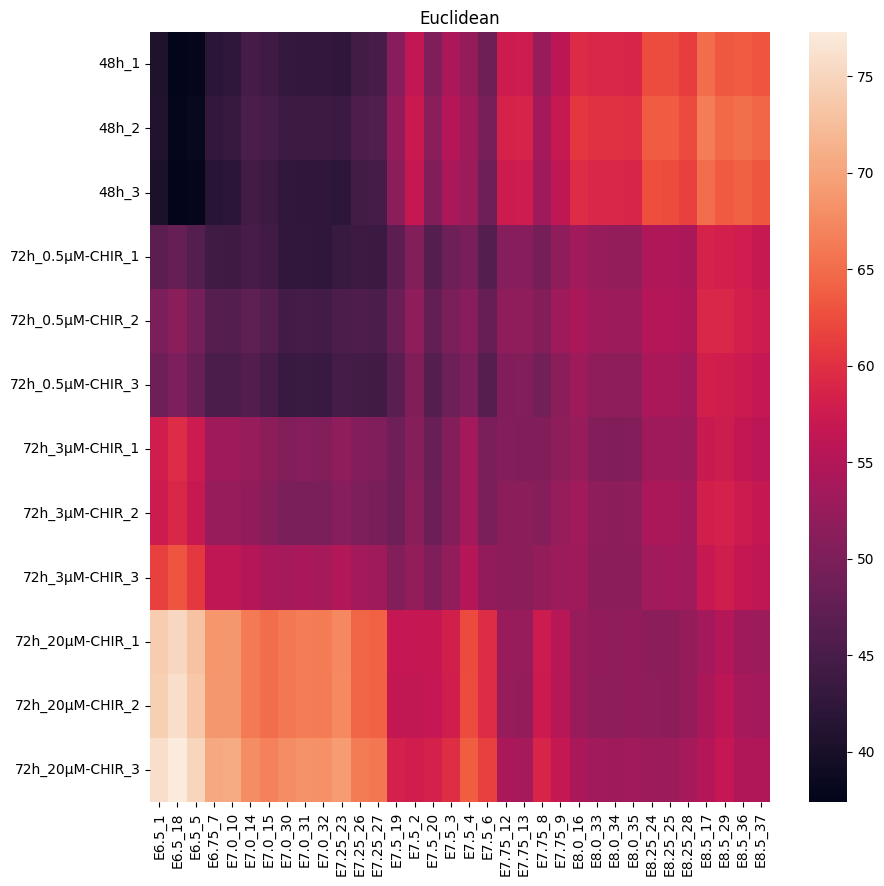

In [9]:
fig, ax = plt.subplots(1,figsize=(10,10))
sns.heatmap(d_euclidean, ax=ax)
ax.set_title("Euclidean")
fig.show()

plt.savefig(f"results/chir_conditions_analysis_heatmap_overlap.{save_format}",bbox_inches="tight",transparent=True)

## Averaged distance matrix

The same but averaged over conditions.

In [10]:
# Order to plot the bulk conditions
order = ['48h', '72h_0.5μM-CHIR', '72h_3μM-CHIR', '72h_20μM-CHIR']

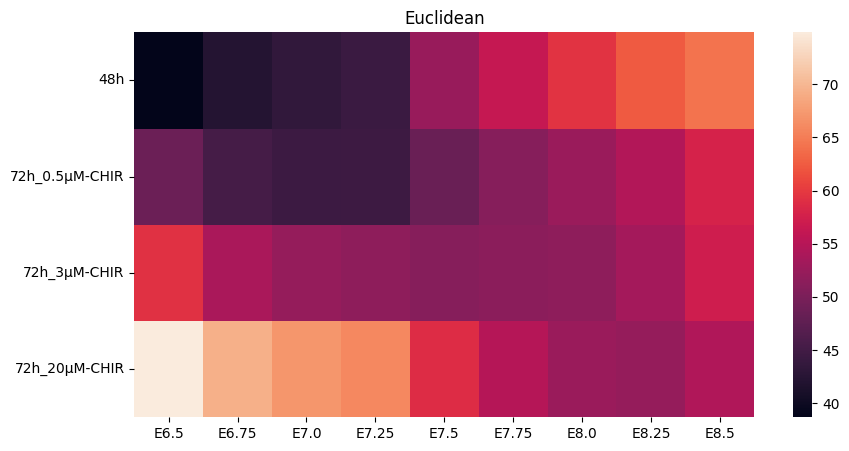

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
d_euclidean_ = d_euclidean.groupby([i[:-2] for i in d_euclidean.index.values]).mean()
d_euclidean_ = d_euclidean_.T.groupby([i.split("_")[0] for i in d_euclidean_.columns.values]).mean().T
sns.heatmap(d_euclidean_.loc[order,:], ax=ax)
ax.set_title("Euclidean");

plt.savefig(f"results/chir_conditions_analysis_heatmap_overlap_mean.{save_format}",bbox_inches="tight",transparent=True)

## Average Gene Overlap

This is a list of common genes expressed in both datasets where we can see similarities in the gene patterns by stages.

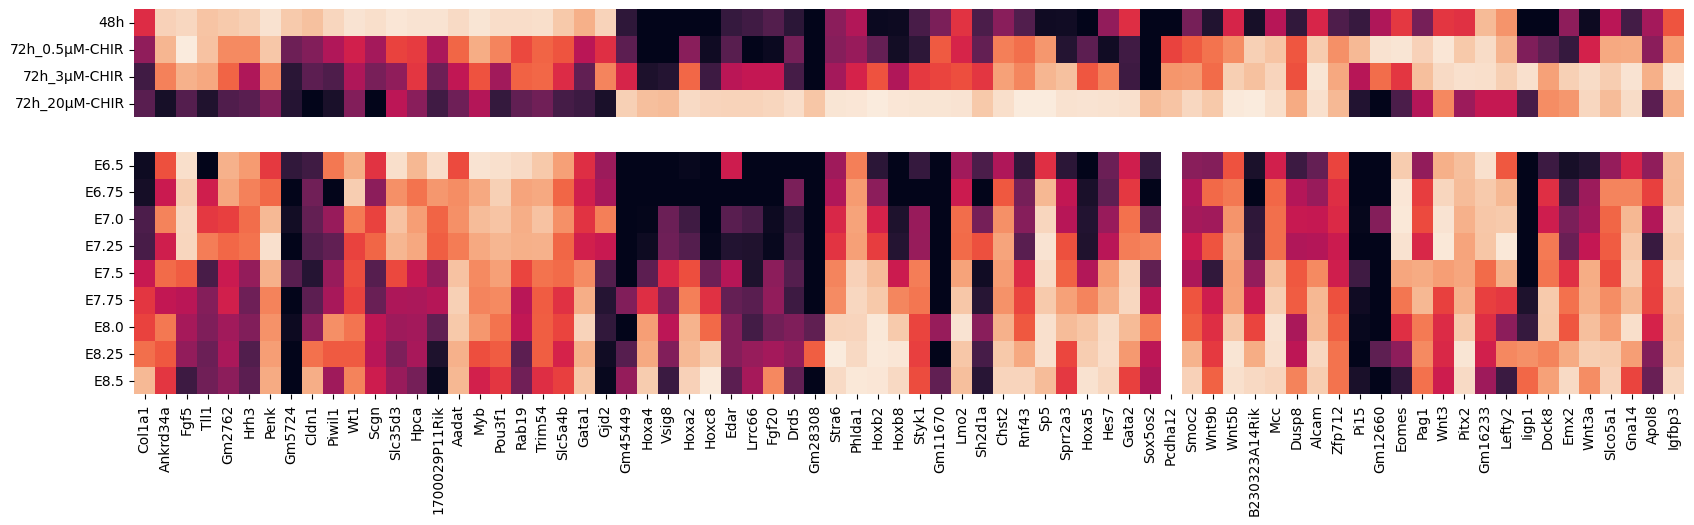

In [12]:
#This is just to generate a clustermap on the genes
l = [int(i[1:]) for i in fs.get_feature_names_out()]
names = df_gastruloid.columns.values[l]
df1_selected = pd.DataFrame(fs.transform(df_gastruloid.values),index=df1.index,columns=names)
df1_selected = df1_selected.div(df1_selected.max(axis=0),axis=1)
fig_ = sns.clustermap(df1_selected,row_cluster=False,figsize=(20,10),metric="cosine")
plt.close()

#This is to actually make the plot
t = [i.get_text() for i in fig_.ax_heatmap.get_xticklabels()]

fig,ax = plt.subplots(2,1,figsize=(20,5), gridspec_kw={'height_ratios': [4, 9]})

#Gastruloid heatmap
df1_selected = df1.loc[:,t]
df1_selected = df1_selected.div(df1_selected.max(axis=0),axis=1)
df1_selected_ = df1_selected.groupby([i[:-2] for i in df1_selected.index.values]).mean()
sns.heatmap(df1_selected_.loc[order,:],ax=ax[0],cbar=False)
ax[0].set_xticks([])
ax[0].set_xticklabels([])
ax[0].set_xlabel("")

#Mouse heatmap
df2_selected = df2.loc[:,t]
df2_selected = df2_selected.div(df2_selected.max(axis=0),axis=1)
df2_selected_ = df2_selected.groupby([i.split("_")[0] for i in df2_selected.index.values]).mean()
sns.heatmap(df2_selected_,ax=ax[1],cbar=False)
ax[1].set_xlabel("");

plt.savefig(f"results/chir_conditions_analysis_heatmap_genes.{save_format}",bbox_inches="tight",transparent=True)

# Robustness analysis

In this analysis we show that, changing the parameters of the analysis, we still obtain similar results. So the analysis is robust to perturbations.

In [13]:
conditions = [
    {"variance_threshold":.5,"n_pcs":None,"metric":"euclidean"},
    {"variance_threshold":.8,"n_pcs":4,"metric":"euclidean"},
    {"variance_threshold":.8,"n_pcs":None,"metric":"euclidean"},
    {"variance_threshold":0.3,"n_pcs":13,"metric":"euclidean"},
    {"variance_threshold":.8,"n_pcs":None,"metric":"cosine"},
    {"variance_threshold":1,"n_pcs":None,"metric":"euclidean"},
    {"variance_threshold":.8,"n_pcs":13,"metric":"euclidean"},
]

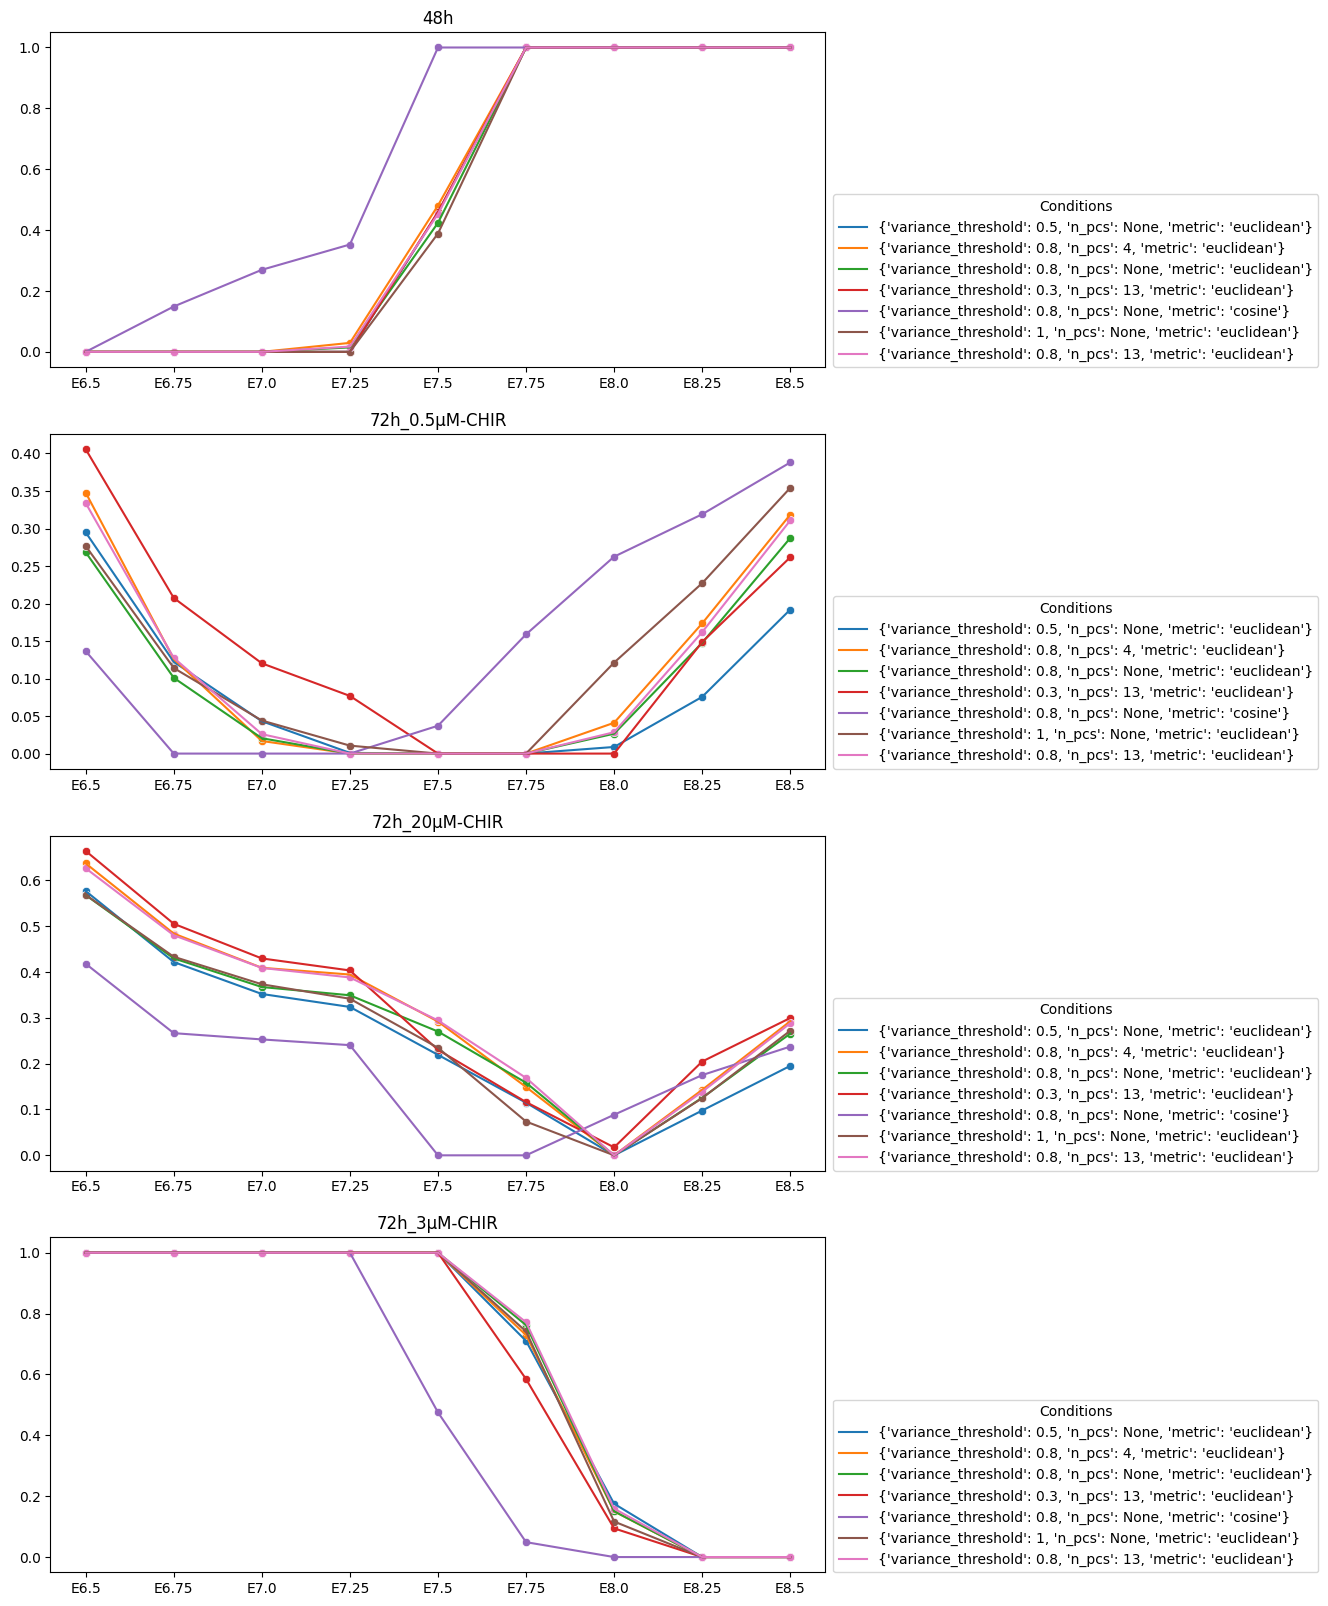

In [14]:
fig,ax = plt.subplots(4,1,figsize=(10,20))

for i in conditions:

    # Threshold
    fs_ = VarianceThreshold(threshold=i["variance_threshold"])
    fs_.fit(df1.values)
    l = [int(i[1:]) for i in fs_.get_feature_names_out()]

    df1_pca = pd.DataFrame(fs_.transform(df1.values),index=df1.index)
    df2_pca = pd.DataFrame(fs_.transform(df2.values),index=df2.index)
    
    #PCA
    if i["n_pcs"] != None:
        names = df1.columns.values[l]
        df1_fs = pd.DataFrame(fs_.transform(df1.values),index=df1.index,columns=names)
        pca = PCA(n_components=min(i["n_pcs"],df1_fs.shape[0]-1))
        pca.fit(df1_fs.values)
        df1_pca = pd.DataFrame(pca.transform(fs_.transform(df1.values)),index=df1.index)
        df2_pca = pd.DataFrame(pca.transform(fs_.transform(df2.values)),index=df2.index)

    d_euclidean,m_euclidean = distance_table(df1_pca,df2_pca,metric=i["metric"])
    
    d_euclidean_ = d_euclidean.groupby([i[:-2] for i in d_euclidean.index.values]).mean()
    d_euclidean_ = d_euclidean_.T.groupby([i.split("_")[0] for i in d_euclidean_.columns.values]).mean().T

    for j,k in enumerate(order):
        y = (d_euclidean_.loc[k,:]-d_euclidean_.min())/(d_euclidean_.max()-d_euclidean_.min())
        sns.lineplot(x=d_euclidean_.columns.values,y=y,ax=ax[j],label=i)
        sns.scatterplot(x=d_euclidean_.columns.values,y=y,ax=ax[j])

for i,j in enumerate(d_euclidean_.index.values):
    ax[i].legend(loc=(1.01,0),title="Conditions")
    ax[i].set_ylabel("")
    ax[i].set_title(j)

plt.savefig(f"results/chir_conditions_analysis_robustness.{save_format}",bbox_inches="tight",transparent=True)

# PCA analysis

In [15]:
fs = VarianceThreshold(threshold=.8)
fs.fit(df1.values)

print("Retained: ",len(fs.get_feature_names_out()))

Retained:  922


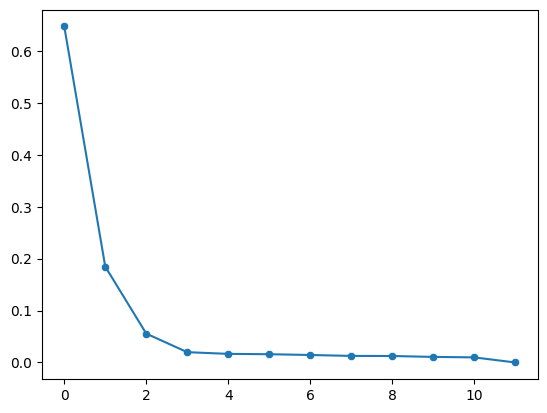

In [16]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
pca = PCA(n_components=12)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

plt.savefig(f"results/chir_conditions_analysis_pca_explaiden_variance.{save_format}",bbox_inches="tight",transparent=True)

In [17]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]]
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(3,df1.shape[0]-1))
pca.fit(fs.transform(df1.values));

## Representation

Show the PCA components and the Pijuan-Sala projection. The PCA captures time evolution.

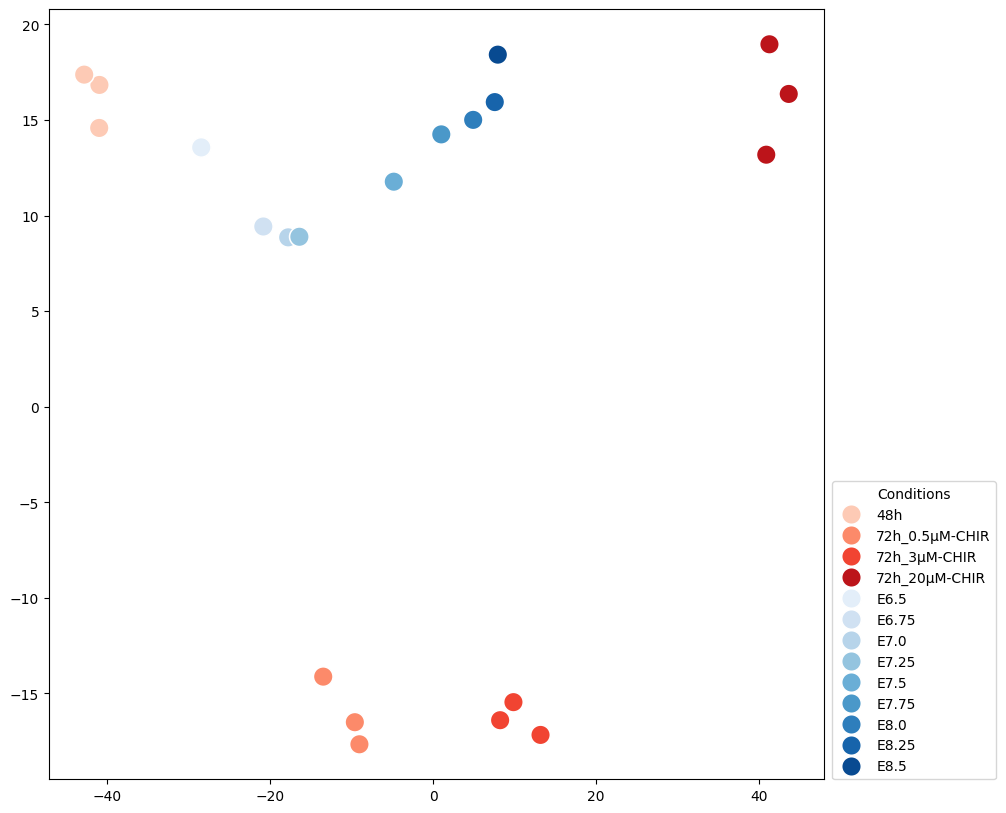

In [18]:
fig,ax = plt.subplots(figsize=(10,10))

x = pca.transform(fs.transform(df1.values))
p = sns.scatterplot(x=x[:,0],y=x[:,1],
                hue=df_gastruloid_metadata["Condition"],
                s=200,palette="Reds")

x = pca.transform(fs.transform(df2.values))
df_embryo_ = pd.DataFrame(x,index=df2.index.values).groupby([i.split("_")[0] for i in df2.index.values]).mean()
p2 = sns.scatterplot(x=df_embryo_.values[:,0],y=df_embryo_.values[:,1],hue=[i for i in df_embryo_.index.values],marker="o",palette="Blues",s=200)

ax.legend(loc=(1.01,0),title="Conditions")

plt.savefig(f"results/chir_conditions_analysis_scatterplot.{save_format}",bbox_inches="tight",transparent=True)

## Loadings

This shows that buttom-left to up-right is capturing changes in genes like (T, Wnt3a, etc.) and up-left to bottom-right capturing expressioon of genes like (Hox-family).

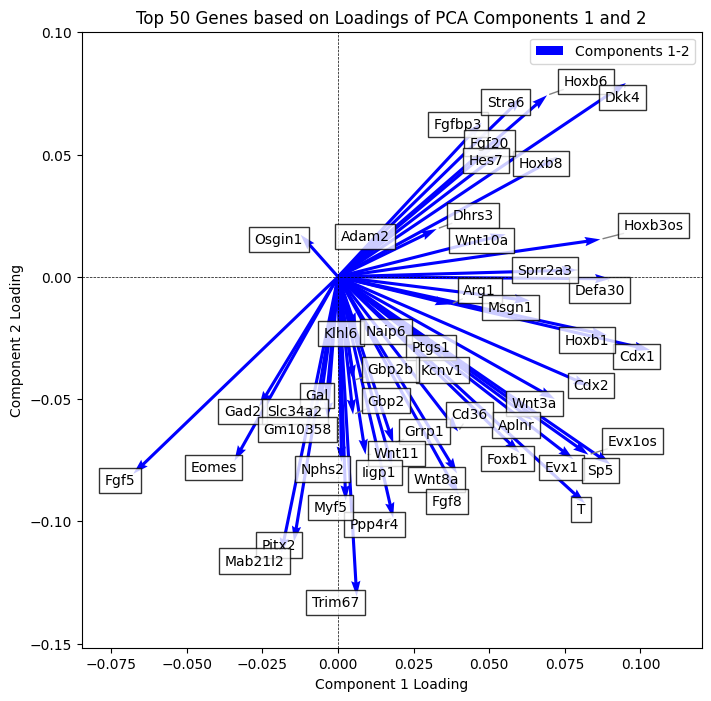

In [19]:
plot_loadings_components(pca,0,1,df1_fs.columns.values,50)

plt.savefig(f"results/chir_conditions_analysis_heatmap_loadings.{save_format}",bbox_inches="tight",transparent=True)